In [17]:
import menzalib as mz
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.constants as con
from scipy.stats import linregress
from numdifftools.nd_algopy import Gradient, Derivative

In [18]:
def theta(x):
    if x>0: return 1
    return 0

def f2t(V,V0,a,b,I0):
    return a*theta(V0-V)*(V0-V)**2+b*V+I0
f2=np.vectorize(f2t)

def cifrat(x):
    i=0
    while (x-np.round(x,-i))!=0: i=i-1
    if i<-13: return -13
    return i
cifra=np.vectorize(cifrat)

def lint(x,a,b):
    return x*a+b
lin=np.vectorize(lint)

# Fit con la funzione con esponente fisso
Sto usando la funzione `f2(V,V0,a,b,I0,2)`$=a(V_0-V)^2\theta(V_0-V)+bV+I_0$

Le immagini sono salvate nella cartella `immagini/` e le tabelle per latex nella cartella `tabelle/`

In [44]:
lung=[450,499,545,577]
dlung=[9.6,11.1,11.68,10]/np.sqrt(4)
v0=[1.213,0.951,0.774,0.715]
dv0=np.zeros(len(v0))
p0=np.zeros(len(lung))
for i in range(len(lung)):
    
    #raccolta dati e calcolo deli errori
    V,I=np.genfromtxt('dati/'+str(lung[i])+'nm.txt',unpack='True')
    I=I*1e-12
    V=V*1e-3
    dV=mz.dVdig(V)
    dI=np.zeros(len(I))
    for j in range(len(I)):
        dI[j]=np.sqrt((I[j]*4e-3)**2+10.0**(cifra(I[j])*2))
        if I[j]==0: dI[j]=1e-13
    p0[0]=v0[i]

    #fit
    popt,pcov,a,chi2,pval=mz.curve_fitdx(f2,V,I,dV,dI,p0,chi2pval=1,absolute_sigma=True)
    #v0[i]=popt[0]
    #dv0[i]=np.sqrt(pcov[0][0])
    
    #plottaggio
    plt.figure()
    plt.title('Fotocorrente con lunghezza d\'onda di '+str(lung[i])+'nm')
    plt.subplot(211)
    plt.errorbar(V,-I*1e12,xerr=dV,yerr=dI*1e12,fmt='.')
    plt.xlabel('Voltaggio[V]')
    plt.ylabel('Corrente[pA]')
    x=np.linspace(V[0],V[-1],100)
    y=f2(x,*popt)
    plt.plot(x,-y*1e12)
    
    plt.subplots_adjust(hspace=0.5)
    def ft(V):
        return f2(V,*popt)
    
    plt.subplot(212)
    sigma_eff=np.empty(len(dI))
    for j in range(len(dI)):
        sigma_eff[j]=np.sqrt((dI[j])**2+(Derivative(ft)(V[j])*dV[j])**2)
    plt.errorbar(V,-(I-f2(V,*popt))*1e12,xerr=dV,yerr=sigma_eff*1e12,fmt='.')
    plt.xlabel('Voltaggio[V]')
    plt.ylabel('Residui della corrente[pA]')
    x=np.linspace(V[0],V[-1],100)
    y=np.zeros(len(x))
    plt.plot(x,y)
    plt.savefig('immagini/'+str(lung[i])+'nm.eps',format='eps')
    plt.close()
    
    #faccio la tabella con i parametri di fit
    col1=['$V_0$','$a$','$b$','$I_0$','$\chi^2$']
    col2=mz.ne_tex(popt,np.sqrt(pcov.diagonal()))
    col2=np.append(col2,mz.ns_tex(chi2))
    mz.mat_tex([col1,col2],'Parametri di Fit & Valori di Fit','tabelle/'+str(lung[i])+'nm.tex')
    
    #faccio la tabella con i dati grezzi
    col1=mz.ns_tex(V*1000,1,dV*1000)
    col2=mz.ns_tex(dV*1000,1,dV*1000)
    col3=mz.ns_tex(I*1e12,1,dI*1e12)
    col4=mz.ns_tex(dI*1e12,1,dI*1e12)
    mz.mat_tex([col1,col2,col3,col4],'$V[mV]$ & $\\sigma V[mV]$ & $I[pA]$ & $\\sigma I[pA]$',
              'tabelle/completi'+str(lung[i])+'nm.tex')

#porto la lunghezza d'onda in metri
dlung=np.array(dlung)*1e-9
lung=np.array(lung)*1e-9

# Fit per determinare $h/c$

Per la conservazione dell'energia $eV_0=h\nu(\lambda)+W_0$

visto che $\nu=\frac1T$ e $\omega=\frac{2\pi}T$ allora $\nu=2\pi\omega$, inoltre $\frac\omega k=c$ e $k=\frac{2\pi}\lambda$

quindi $c=\frac{\omega\lambda}{2\pi}=\nu\lambda$, quindi $\nu(\lambda)=\frac c\lambda$

Morale della favola $V_0=\frac{hc}{e\lambda}+\frac{W_0}e$ e $\nu=\frac{eV_0}{h}-\frac{W_0}{h}$

$(3.4$ $\pm$ $0.2)\times 10^{-15}$
4.135667662340164e-15


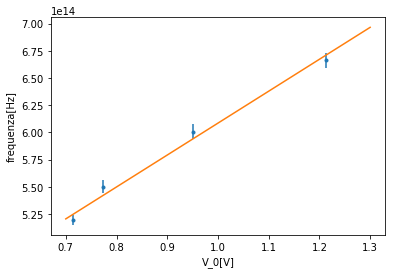

In [45]:
#passo nelle frequenze
dfreq=mz.drapp(con.c,0,lung,dlung)
freq=np.empty(len(lung))
for i in range(len(lung)): freq[i]=con.c/lung[i]

#faccio il fit
p0=linregress(v0,freq)[:2]
popt,pcov,a,chi2,pval=mz.curve_fitdx(lin,v0,freq,dv0,dfreq,p0,absolute_sigma=True,chi2pval=1)
print(mz.ne_tex(1/popt[0],mz.drapp(1,0,popt[0],np.sqrt(pcov[0][0]))))
print(con.h/con.e)

#plotto
x=np.linspace(0.7,1.3,10)
y=lin(x,*popt)
plt.figure()
plt.errorbar(v0,freq,xerr=dv0,yerr=dfreq,fmt='.')
plt.plot(x,y)
plt.xlabel('V_0[V]')
plt.ylabel('frequenza[Hz]')
#plt.savefig('immagini/fit.eps',format='eps')

#tabella parametri di fit
col1=['$e/h$','$W_o/h$','$\chi^2$']
col2=mz.ne_tex(popt,np.sqrt(pcov.diagonal()))
col2=np.append(col2,mz.ns_tex(chi2))
#mz.mat_tex([col1,col2],'Parametri di Fit & Valori di Fit','tabelle/e_su_h.tex')

#tabella dati
col2=mz.ne_tex(freq,dfreq)
col1=mz.ne_tex(v0,dv0)
#mz.mat_tex([col1,col2],'$V_0[V]$ & $\\nu[Hz]$','tabelle/plank.tex')

$e/h=(3.0\pm0.1)\times 10^{14}$ il valore teorico è $2.42\times 10^{14}$, che bello

1.3017775916584449 0.0032795563578695034
